In [1]:
!pip install tensorflow opencv-python matplotlib albumentations

   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   --- ------------------------------------ 3.4/38.9 MB 22.3 MB/s eta 0:00:02
   ---- ----------------------------------- 4.7/38.9 MB 10.9 MB/s eta 0:00:04
   ----- ---------------------------------- 5.8/38.9 MB 9.3 MB/s eta 0:00:04
   ------ --------------------------------- 6.3/38.9 MB 8.4 MB/s eta 0:00:04
   ------- -------------------------------- 6.8/38.9 MB 6.6 MB/s eta 0:00:05
   ------- -------------------------------- 7.1/38.9 MB 5.7 MB/s eta 0:00:06
   ------- -------------------------------- 7.3/38.9 MB 5.2 MB/s eta 0:00:07
   -------- ------------------------------- 7.9/38.9 MB 4.6 MB/s eta 0:00:07
   -------- ------------------------------- 8.4/38.9 MB 4.3 MB/s eta 0:00:08
   --------- ------------------------------ 8.9/38.9 MB 4.2 MB/s eta 0:00:08
   --------- ------------------------------ 9.7/38.9 MB 4.1 MB/s eta 0:00:08
   ---------- ----------------------------- 10.5/38.9 MB 4.0 MB/s eta 0:00:08
   

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
monai 1.4.0 requires numpy<2.0,>=1.24, but you have numpy 2.1.3 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[INFO] Using device: cuda
[INFO] Loaded 547 images and masks.


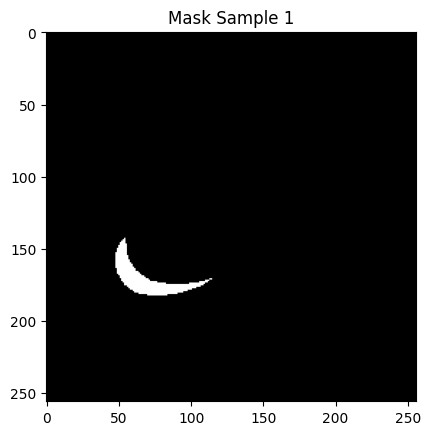

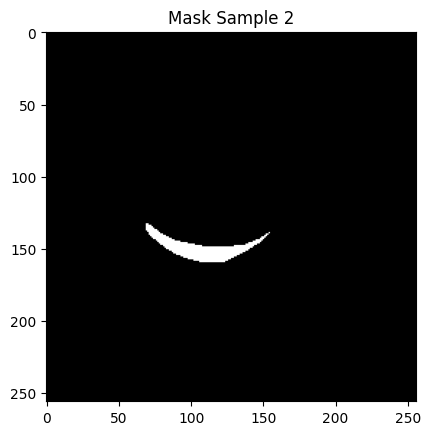

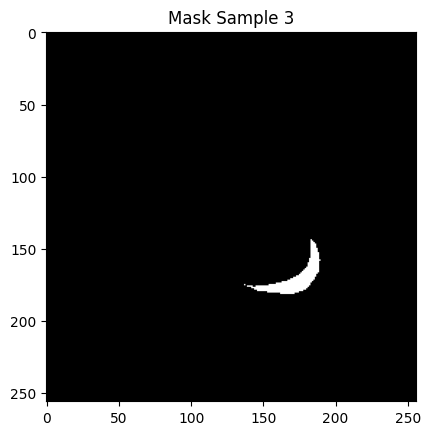

[INFO] Dataset split into training and validation sets.
[INFO] Starting training...
[INFO] Epoch 1/20 | Loss: 0.6393 | Dice: 0.0000
[INFO] Epoch 2/20 | Loss: 0.5144 | Dice: 0.0000
[INFO] Epoch 3/20 | Loss: 0.4307 | Dice: 0.1405
[INFO] Epoch 4/20 | Loss: 0.2158 | Dice: 0.6460
[INFO] Epoch 5/20 | Loss: 0.1740 | Dice: 0.7061
[INFO] Epoch 6/20 | Loss: 0.1588 | Dice: 0.7359
[INFO] Epoch 7/20 | Loss: 0.1494 | Dice: 0.7448
[INFO] Epoch 8/20 | Loss: 0.1411 | Dice: 0.7607
[INFO] Epoch 9/20 | Loss: 0.1373 | Dice: 0.7668
[INFO] Epoch 10/20 | Loss: 0.1307 | Dice: 0.7779
[INFO] Epoch 11/20 | Loss: 0.1305 | Dice: 0.7793
[INFO] Epoch 12/20 | Loss: 0.1224 | Dice: 0.7893
[INFO] Epoch 13/20 | Loss: 0.1216 | Dice: 0.7922
[INFO] Epoch 14/20 | Loss: 0.1192 | Dice: 0.7949
[INFO] Epoch 15/20 | Loss: 0.1178 | Dice: 0.7986
[INFO] Epoch 16/20 | Loss: 0.1140 | Dice: 0.8043
[INFO] Epoch 17/20 | Loss: 0.1163 | Dice: 0.8027
[INFO] Epoch 18/20 | Loss: 0.1093 | Dice: 0.8123
[INFO] Epoch 19/20 | Loss: 0.1099 | Dice: 0

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from sklearn.model_selection import train_test_split

# Set updated paths
IMAGE_DIR = "Eye Conjunctiva Segmentation Dataset/Images"
MASK_DIR = "Eye Conjunctiva Segmentation Dataset/Masks Annotator 1"
IMG_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")

# 2. Load and preprocess dataset

def load_data(img_dir, mask_dir, img_size):
    images = []
    masks = []
    filenames = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0]))
    for filename in filenames:
        img_path = os.path.join(img_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask[:, :, 2]  # Extract red channel
        mask = (mask > 50).astype(np.float32)  # Threshold red channel
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    print(f"[INFO] Loaded {len(images)} images and masks.")

    # Sanity check: visualize first 3 masks
    for i in range(3):
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Mask Sample {i+1}")
        plt.show()

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

images, masks = load_data(IMAGE_DIR, MASK_DIR, IMG_SIZE)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
print("[INFO] Dataset split into training and validation sets.")

# 3. Data augmentation
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3)
])

def augment_data(images, masks):
    aug_imgs, aug_masks = [], []
    for img, mask in zip(images, masks):
        augmented = augment(image=img, mask=mask[:,:,0])
        aug_img = augmented['image']
        aug_mask = augmented['mask']
        aug_mask = np.expand_dims(aug_mask, axis=-1)
        aug_imgs.append(aug_img)
        aug_masks.append(aug_mask)
    return np.array(aug_imgs), np.array(aug_masks)

aug_X_train, aug_y_train = augment_data(X_train, y_train)

# 4. Custom Dataset
class ConjunctivaDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].transpose(2, 0, 1)
        mask = self.masks[idx].transpose(2, 0, 1)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

train_dataset = ConjunctivaDataset(aug_X_train, aug_y_train)
val_dataset = ConjunctivaDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# 5. U-Net Model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))

model = UNet().to(DEVICE)

# Combined BCE + Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()
        intersection = (preds * targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.smooth)
        return 1 - dice.mean()

dice_loss_fn = DiceLoss()
bce_loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def combined_loss(preds, targets):
    return 0.5 * bce_loss_fn(preds, targets) + 0.5 * dice_loss_fn(preds, targets)

# Dice score metric

def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum().item()
    total = preds.sum().item() + targets.sum().item()
    if total == 0:
        return 1.0
    dice = (2. * intersection) / total
    return dice

# 6. Train model
EPOCHS = 20
print("[INFO] Starting training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_dice = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_dice += dice_score(preds, masks)
    avg_loss = train_loss / len(train_loader)
    avg_dice = train_dice / len(train_loader)
    print(f"[INFO] Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f}")
print("[INFO] Training complete.")

# 7. Save model
torch.save(model.state_dict(), "conjunctiva_unet_model.pth")
print("[INFO] Model saved as 'conjunctiva_unet_model.pth'")

# 8. Inference on new image
def predict_image(image_path):
    print(f"[INFO] Predicting on image: {image_path}")
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img / 255.0
    img_tensor = torch.tensor(img_norm.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(img_tensor)[0]
        mask_pred = (pred.cpu().numpy().squeeze() > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask_pred, cmap='gray')
    plt.show()
    print("[INFO] Prediction complete.")

# Example usage:
# predict_image("Eye Conjunctiva Segmentation Dataset/Images/1.png")


In [ ]:
torch.save(model.state_dict(), 'conjunctiva_unet_model.pth')
print("[INFO] Model saved as 'conjunctiva_unet_model.pth'")


[INFO] Model saved as 'conjunctiva_unet_model.pth'


[INFO] Predicting on image: Eye Conjunctiva Segmentation Dataset/Images/100.png


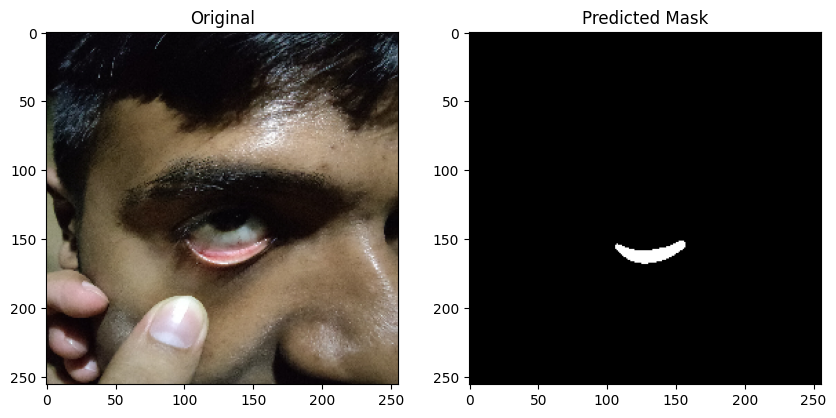

[INFO] Prediction complete.
[INFO] Predicting on image: Eye Conjunctiva Segmentation Dataset/Images/3.png


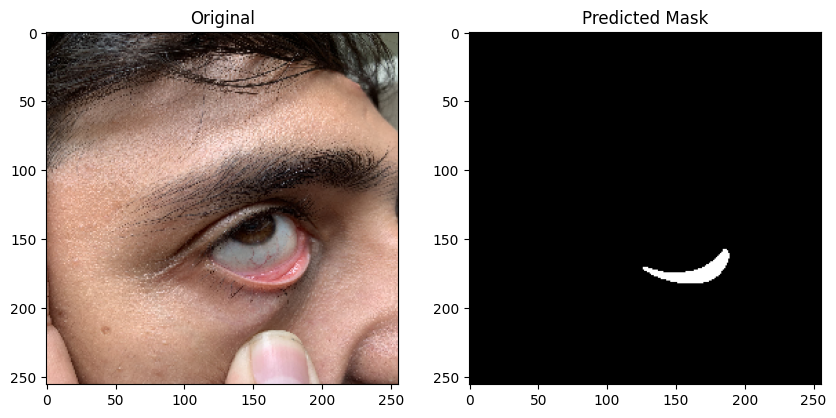

[INFO] Prediction complete.
[INFO] Predicting on image: eye1.jpg


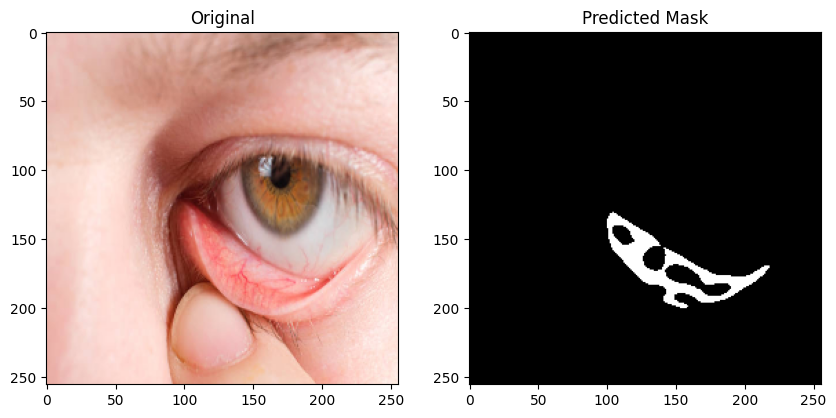

[INFO] Prediction complete.
[INFO] Predicting on image: eye2.jpg


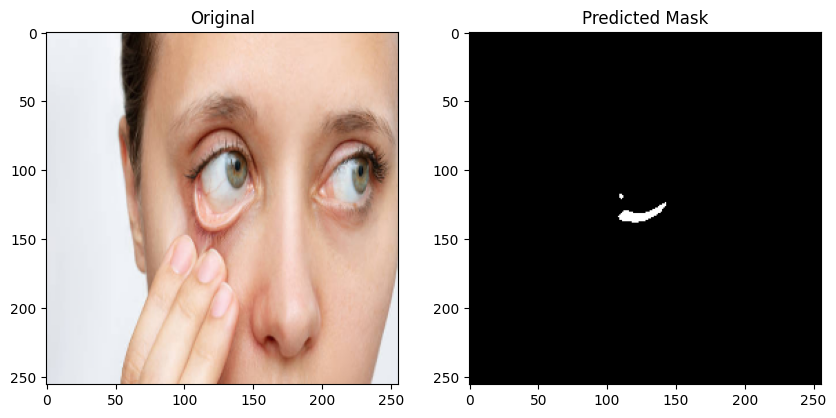

[INFO] Prediction complete.


In [21]:
predict_image("Eye Conjunctiva Segmentation Dataset/Images/100.png")
predict_image("Eye Conjunctiva Segmentation Dataset/Images/3.png")
predict_image("eye1.jpg")
predict_image("eye2.jpg")

C:\Users\admin\AppData\Local\Temp\ipykernel_20540\1350185486.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("conjunctiva_unet_model.pt

[INFO] Model loaded successfully.
[INFO] Predicting on image: Eye Conjunctiva Segmentation Dataset/Images/100.png


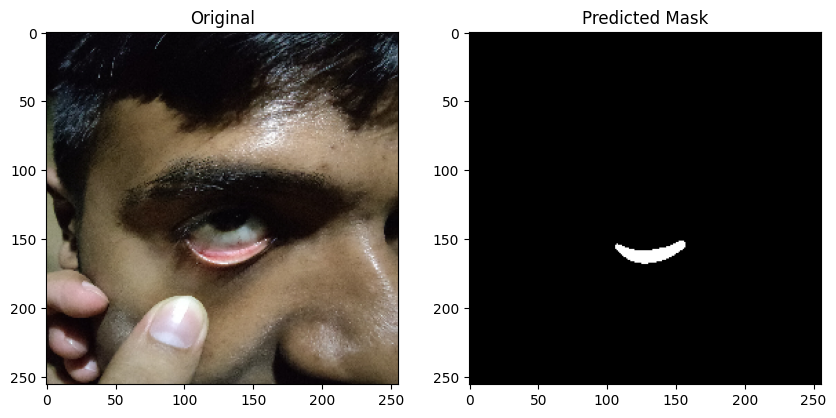

[INFO] Prediction complete.


In [ ]:
#inference
model2 = UNet().to(DEVICE)
model2.load_state_dict(torch.load("conjunctiva_unet_model.pth", map_location=DEVICE))
model2.eval()
print("[INFO] Model loaded successfully.")
def predict_image2(image_path):
    print(f"[INFO] Predicting on image: {image_path}")
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img / 255.0
    img_tensor = torch.tensor(img_norm.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(img_tensor)[0]
        mask_pred = (pred.cpu().numpy().squeeze() > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask_pred, cmap='gray')
    plt.show()
    print("[INFO] Prediction complete.")
predict_image2("Eye Conjunctiva Segmentation Dataset/Images/100.png")